# Tableau Project - Videogame Co.

## Where do we open our new office?

### Instrucciones
#### Somos una compañía de Videogames de 50 empleados. Tenemos que abrir una oficina nueva, pero, ¿dónde?
#### Contamos con 20 desarrolladores, 20 UX/UI y 10 ejecutivos.
#### Tiene que haber alrededor:
#### 1-. Compañías de Software
#### 2-. Buen ratio entre grades compañías y start-ups
#### 3-. Empresas de diseño, diseño web, relacionado con UX
#### 4-. Restaurantes para que los ejecutivos puedan reunirse y hacer negocios 
#### 5-. Evitar compañías muy viejas alrededor

### Variables interesantes que mirar
#### Total money raised (inversiones), competitors, latitud y longitud de oficinas, twitter (influencia de la empresa, API tweety), cathegory code

In [1]:
import re
import pandas as pd
import pymongo

from pandas.io.json import json_normalize

MongoClient = pymongo.MongoClient
client = MongoClient()
db = client.companies
companies = db['companies']

### Todo lo que está comentado es el ejercicio FEO, repitiendo código. 

## Lo he mejorado más adelante creando funciones para hacer un código más eficiente.

In [50]:
# Para evitar compañías viejas alrededor, vamos a considerar qué es una compañía vieja, respondiendo a: ¿En qué año se fundaron
# las compañías más importantes de tecnología hoy en día? Google en el 1998, Intel 1968, Microsoft 1975, Apple 1976
# Tenemos en cuenta las compañías más importantes, ordenadas por valuation amount descending.

#Primero preguntamos a mongo por 1000 compañías de Software para sacar su lat y long.
#Software Co

# cursor1 = db.companies.find({"$and": [{"category_code": 'software'}, {"offices.latitude": {"$not": re.compile("^N.*")}}, {"founded_year": {"$gte": 1965}} ]}).sort("ipo.valuation_amount", pymongo.DESCENDING).limit(1000)

# software_co = list(map(lambda x: [x["name"], x["offices"], x["category_code"]], list(cursor1)))

# software = pd.DataFrame(software_co)

In [51]:
#También preguntamos a mongo por 500 compañías de Mobile para sacar su lat y long, nos interesa tener empresas de movil cerca para sacar videojuegos en el movil.
#Mobile Co

# cursor2 = db.companies.find({"$and": [{"category_code": 'mobile'}, {"offices.latitude": {"$not": re.compile("^N.*")}}, {"founded_year": {"$gte": 1965}} ]}).sort("ipo.valuation_amount", pymongo.DESCENDING).limit(500)

# mobile_co = list(map(lambda x: [x["name"], x["offices"], x["category_code"]], list(cursor2)))

# mobile = pd.DataFrame(mobile_co)

In [52]:
#También nos interesa saber dónde está la competencia, ya que significa que hay mercado en esa zona. 
#Preguntamos a mongo por 1000 compañías de VideoGames para sacar su lat y long.
#VideoGames Co

# cursor3 = db.companies.find({"$and": [{"category_code": 'games_video'}, {"offices.latitude": {"$not": re.compile("^N.*")}}, {"founded_year": {"$gte": 1965}} ]}).sort("ipo.valuation_amount", pymongo.DESCENDING).limit(1000)

# gamesvideo_co = list(map(lambda x: [x["name"], x["offices"], x["category_code"]], list(cursor3)))

# gamesvideo = pd.DataFrame(gamesvideo_co)

In [53]:
#Preguntamos a mongo por 1000 compañías de web para sacar su lat y long.
#Web Co

# cursor4 = db.companies.find({"$and": [{"category_code": 'web'}, {"offices.latitude": {"$not": re.compile("^N.*")}}, {"founded_year": {"$gte": 1965}} ]}).sort("ipo.valuation_amount", pymongo.DESCENDING).limit(1000)

# web_co = list(map(lambda x: [x["name"], x["offices"], x["category_code"]], list(cursor4)))

# web = pd.DataFrame(web_co)


In [54]:
# cos = pd.concat([software, mobile, gamesvideo, web])
# cos.columns = ['Company', 'Address', 'Category']
# print(len(cos))

3384


In [79]:
# cos = cos.dropna(subset=['Address'], axis=0)
# print(len(cos))
# cos.head()

3384


,Company,Address,Category
0,BMC Software,"[{'description': '', 'address1': '2101 City We...",software
1,Rackspace,"[{'description': 'HQ', 'address1': '5000 Walze...",software
2,Jive Software,"[{'description': 'Palo Alto HQ', 'address1': '...",software
3,QlikTech,"[{'description': 'World Headquarters', 'addres...",software
4,Cornerstone OnDemand,"[{'description': 'Headquarters', 'address1': '...",software


In [2]:
# Para evitar compañías viejas alrededor, vamos a considerar qué es una compañía vieja, respondiendo a: ¿En qué año se fundaron
# las compañías más importantes de tecnología hoy en día? Google en el 1998, Intel 1968, Microsoft 1975, Apple 1976
# Tenemos en cuenta las compañías más importantes, ordenadas por valuation amount descending.

def convert_companies(company): 
    return {
        "name": company["name"],
        "category_code": company["category_code"],
        "founded_year": company["founded_year"],
        "number_of_employees": company["number_of_employees"],
        "total_money_raised": company["total_money_raised"],
        "offices": company["offices"]
        }

cursor = companies.find(
    {"$and":
     [
         {"offices.latitude": {"$exists": True}},
         {"founded_year": {"$gte": 1965}}, 
         {"$or": [
             {"category_code": "web"},
             {"category_code": "software"},
             {"category_code": "games_video"},
             {"category_code": "mobile"},
         ]
         }
     ]
    })

geoCompanies = list(map(lambda r: convert_companies(r), cursor))
len(geoCompanies)
# geoCompanies

5694

Queremos tener en cuenta todas las coordenadas de todas las oficinas de cada empresa.
Como al principio había llamado de la misma manera a cada una de las oficinas (ej, IBM era el nombre de todas las oficinas de IBM) Tableau había captado varias coordenadas con el mismo nombre, y había hecho la media entre ellas para plotear una sola oficina en una coordenada 'inventada'. Para solucionar esto, hay que cambiar el nombre a cada una de las oficinas (ej, IBM_office_1, IBM_office_2...) para que dibuje cada una de ellas independientes.

In [3]:
def convert_offices(company):
    
    companies = []
    
    for x in geoCompanies:
        for i, y in enumerate(x["offices"]):
            z = {
            "name": x["name"] + "_office_" + str(i+1),
            "category_code": x["category_code"],
            "founded_year": x["founded_year"],
            "number_of_employees": x["number_of_employees"],
            "total_money_raised": x["total_money_raised"],
            'latitude': y['latitude'],
            'longitude': y['longitude']}
            companies.append(z)
    return companies

offices = convert_offices(geoCompanies)
len(offices)
offices_cos = pd.DataFrame(offices)
offices_cos.head()

,category_code,founded_year,latitude,longitude,name,number_of_employees,total_money_raised
0,web,2005,47.603122,-122.333253,Wetpaint_office_1,47.0,$39.8M
1,web,2005,40.723731,-73.996431,Wetpaint_office_2,47.0,$39.8M
2,software,2005,37.692934,-121.904945,Zoho_office_1,1600.0,$0
3,web,1999,37.506885,-122.247573,Postini_office_1,NaN,$0
4,web,2006,34.090368,-118.393064,Geni_office_1,18.0,$16.5M


In [4]:
# Wrangling

offices_cos = offices_cos.dropna(subset= ["latitude", "longitude"])
null_cols = offices_cos.isnull().sum()
null_cols[null_cols > 0]
                           

number_of_employees    1424
dtype: int64

In [5]:
# Para crear la columna 'position' donde estarán las coordenadas y el type de coordenadas en un diccionario (así lo interpreta Tableau)

position = []

for i in range(len(offices_cos)):
    lat = offices_cos.iloc[i]["latitude"]
    lon = offices_cos.iloc[i]["longitude"]
    point = {"type":"Point", "coordinates": [lon,lat]}
    position.append(point)
    
offices_cos["points"] = position
# offices_cos

In [6]:
# Me lo descargo para importar la versión limpia en MongoDB (para borrar el anterior, --drop en Terminal mongoimport)

offices_cos.to_json('visualize_companies.json', orient="records", lines = True)

Ahora, vamos a definir una función utilizando el '$near' de MongoDB.
Con esta función queremos ver, para cada una de las oficinas, cuántas oficinas tiene cerca en un radio de 1km.
Después creamos una columna con esta información, para dibujarlo en Tableau con círculos más grandes.


In [11]:
client = MongoClient()
db = client.companies
collection = db.clean

co_coords = list(collection.find({"name":{"$exists":"true"}},{"name":1, '_id':0, "points.coordinates":1}))

def find_near(i):
    lat = co_coords[i]["points"]["coordinates"][0]
    lgtd = co_coords[i]["points"]["coordinates"][1]

    local_cursor = collection.find({"points": {"$near": {"$geometry": {
                                                        "type": "Point" ,
                                                        "coordinates": [ lat , lgtd ]},
                                          "$minDistance": 0,
                                          "$maxDistance": 1000}}})
    return list(local_cursor)

near_list = [find_near(i) for i in range(len(co_coords))]
near_count = [len(e) for e in near_list]
#co_coords[i]["points"]["coordinates"][0]

offices_cos["Number of close companies"] = near_count
visualize_near_cos = offices_cos.sort_values(by = "Number of close companies", ascending = False)
visualize_near_cos.head()

,category_code,founded_year,latitude,longitude,name,number_of_employees,total_money_raised,points,Number of close companies
2261,mobile,2006,40.039353,-76.307448,FlyCast_office_1,NaN,$2.1M,"{'type': 'Point', 'coordinates': [-76.307448, ...",136
5177,software,2001,37.785655,-122.398393,Neocase Software_office_1,NaN,$16.5M,"{'type': 'Point', 'coordinates': [-122.398393,...",133
3534,software,2008,37.865027,-122.298737,Shastic_office_1,4.0,$0,"{'type': 'Point', 'coordinates': [-122.2987371...",131
6451,web,2009,51.539591,-0.152505,Bar Exchange_office_1,10.0,$0,"{'type': 'Point', 'coordinates': [-0.1525048, ...",131
138,games_video,1992,37.536172,-122.327323,Jaman_office_1,NaN,$0,"{'type': 'Point', 'coordinates': [-122.327323,...",131


In [12]:
# Me lo descargo para importar en Tableau y dibujar! 

visualize_near_cos.to_json("visualize_near_cos.json", orient="records", lines=True)

#### Finalmente, tras visualizar todos los datos en Tableau, vemos que nuestra decisión final es montar nuestra nueva oficina en Manhattan!!

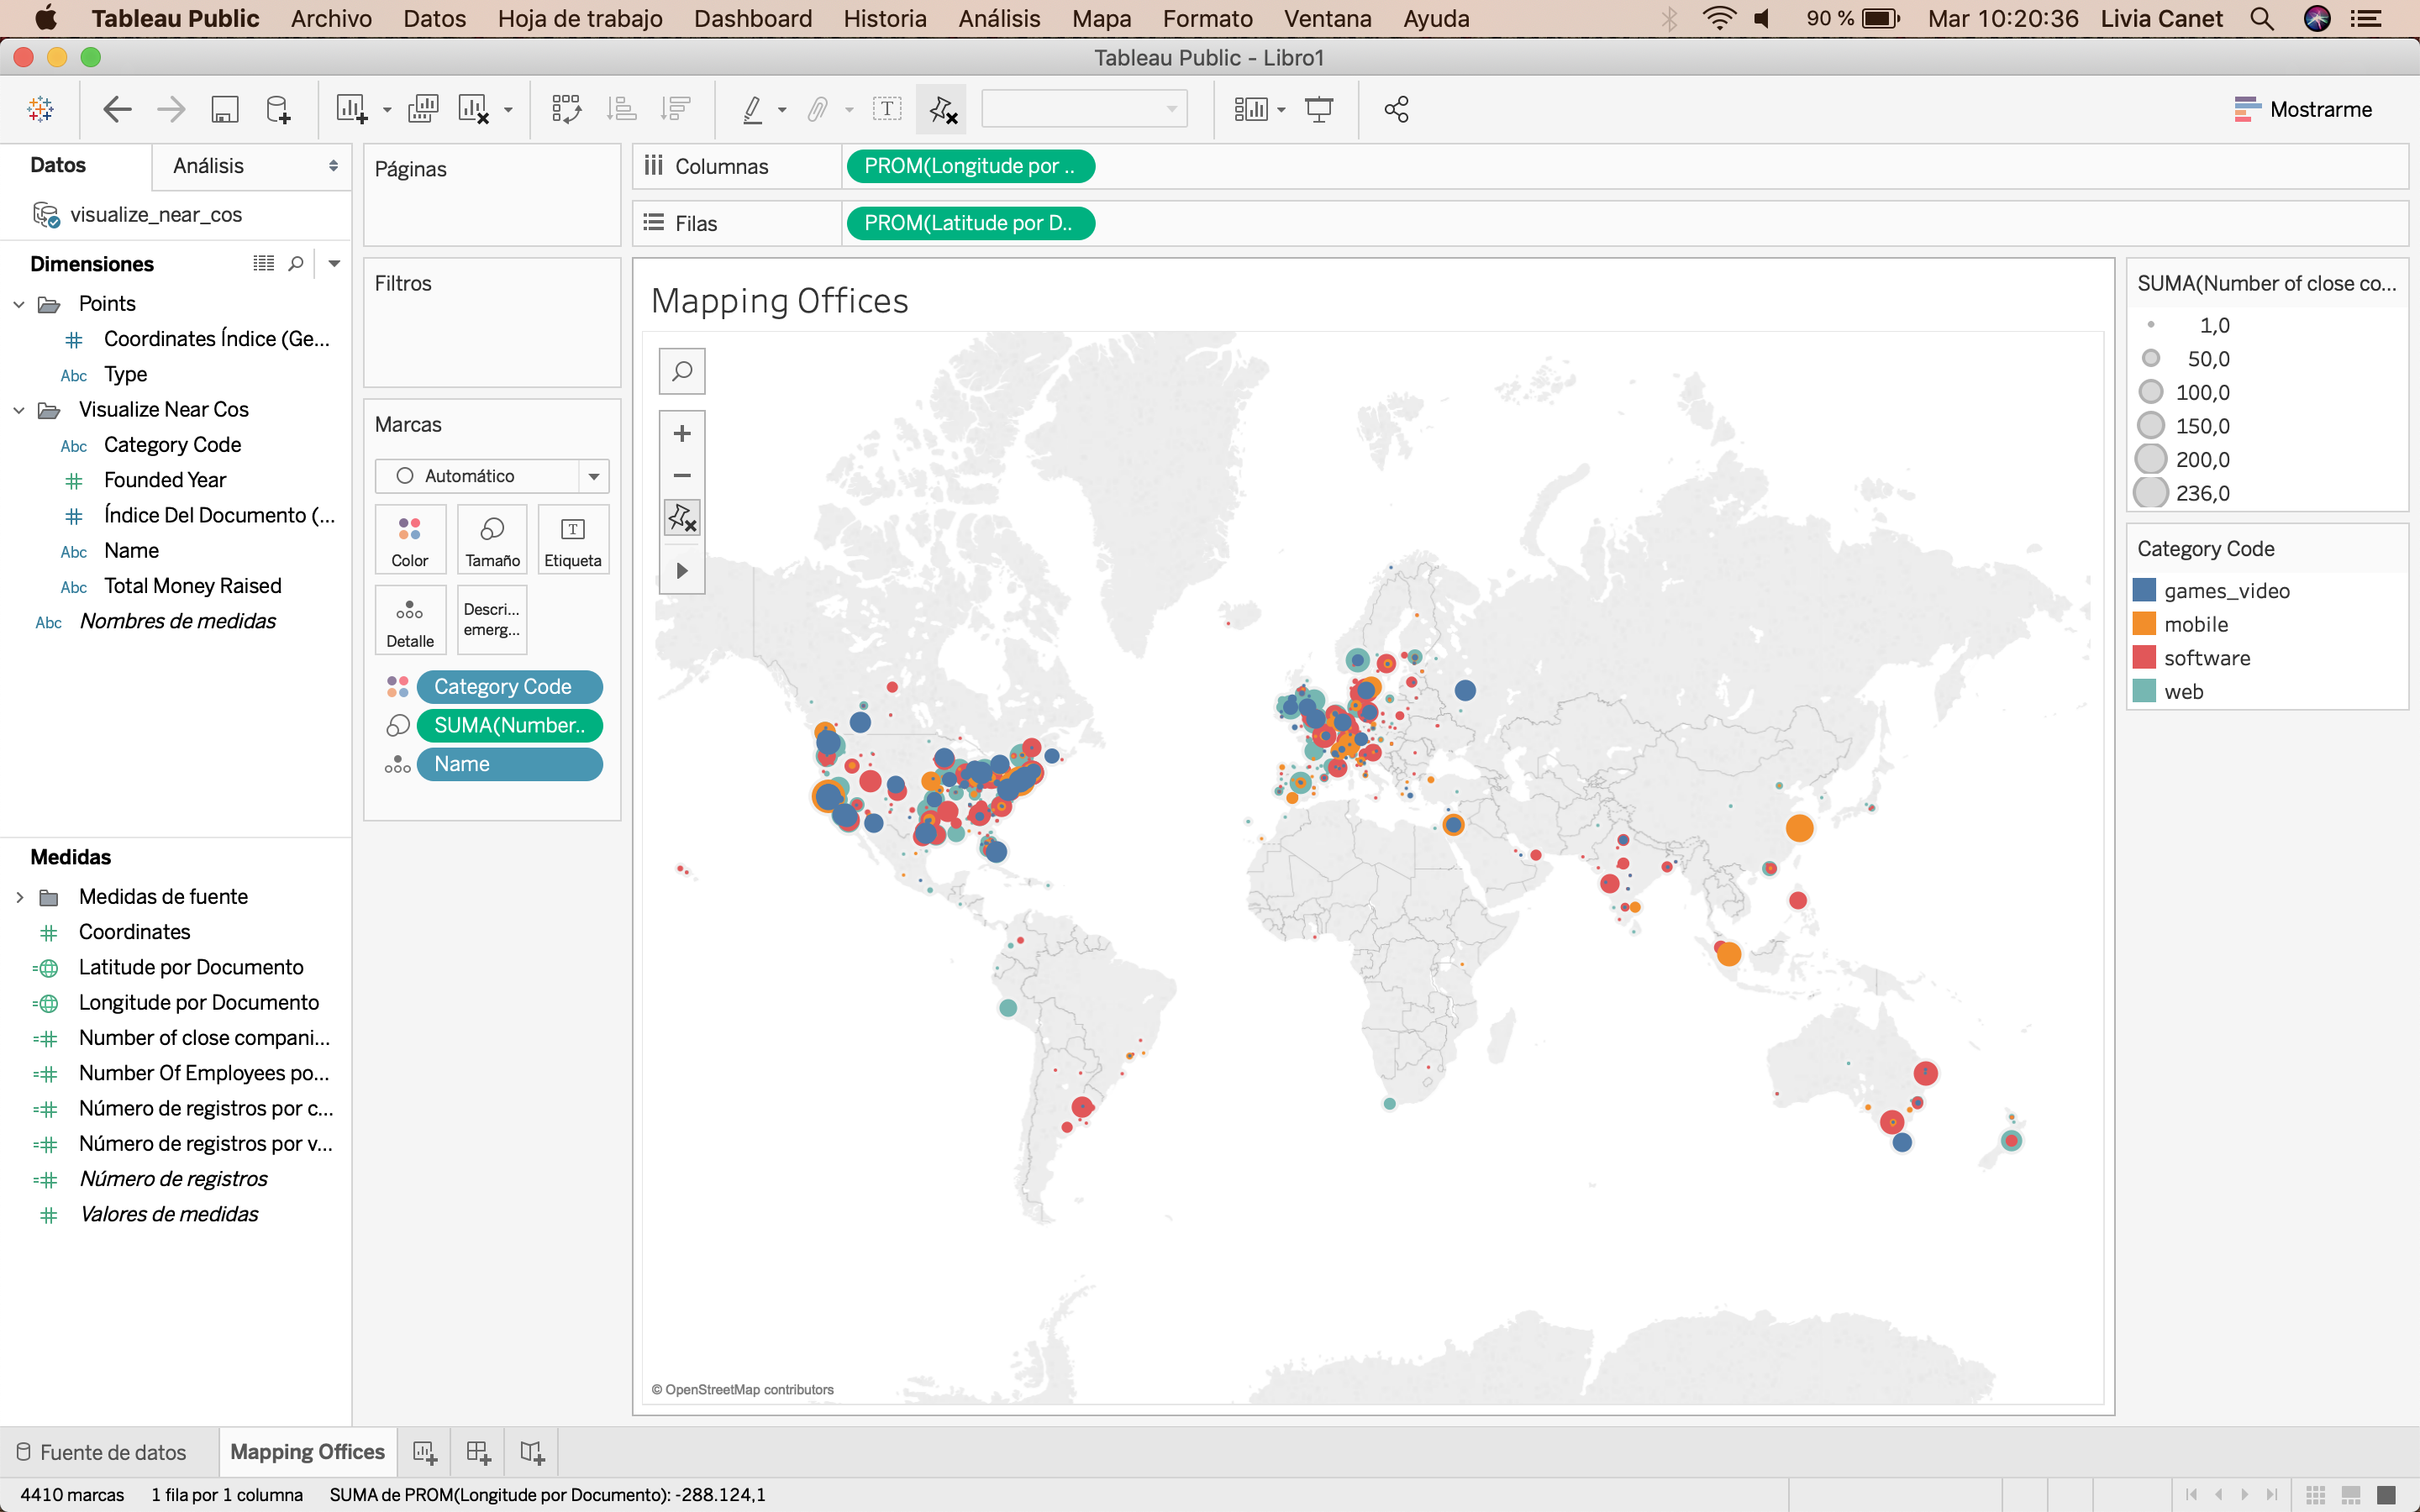

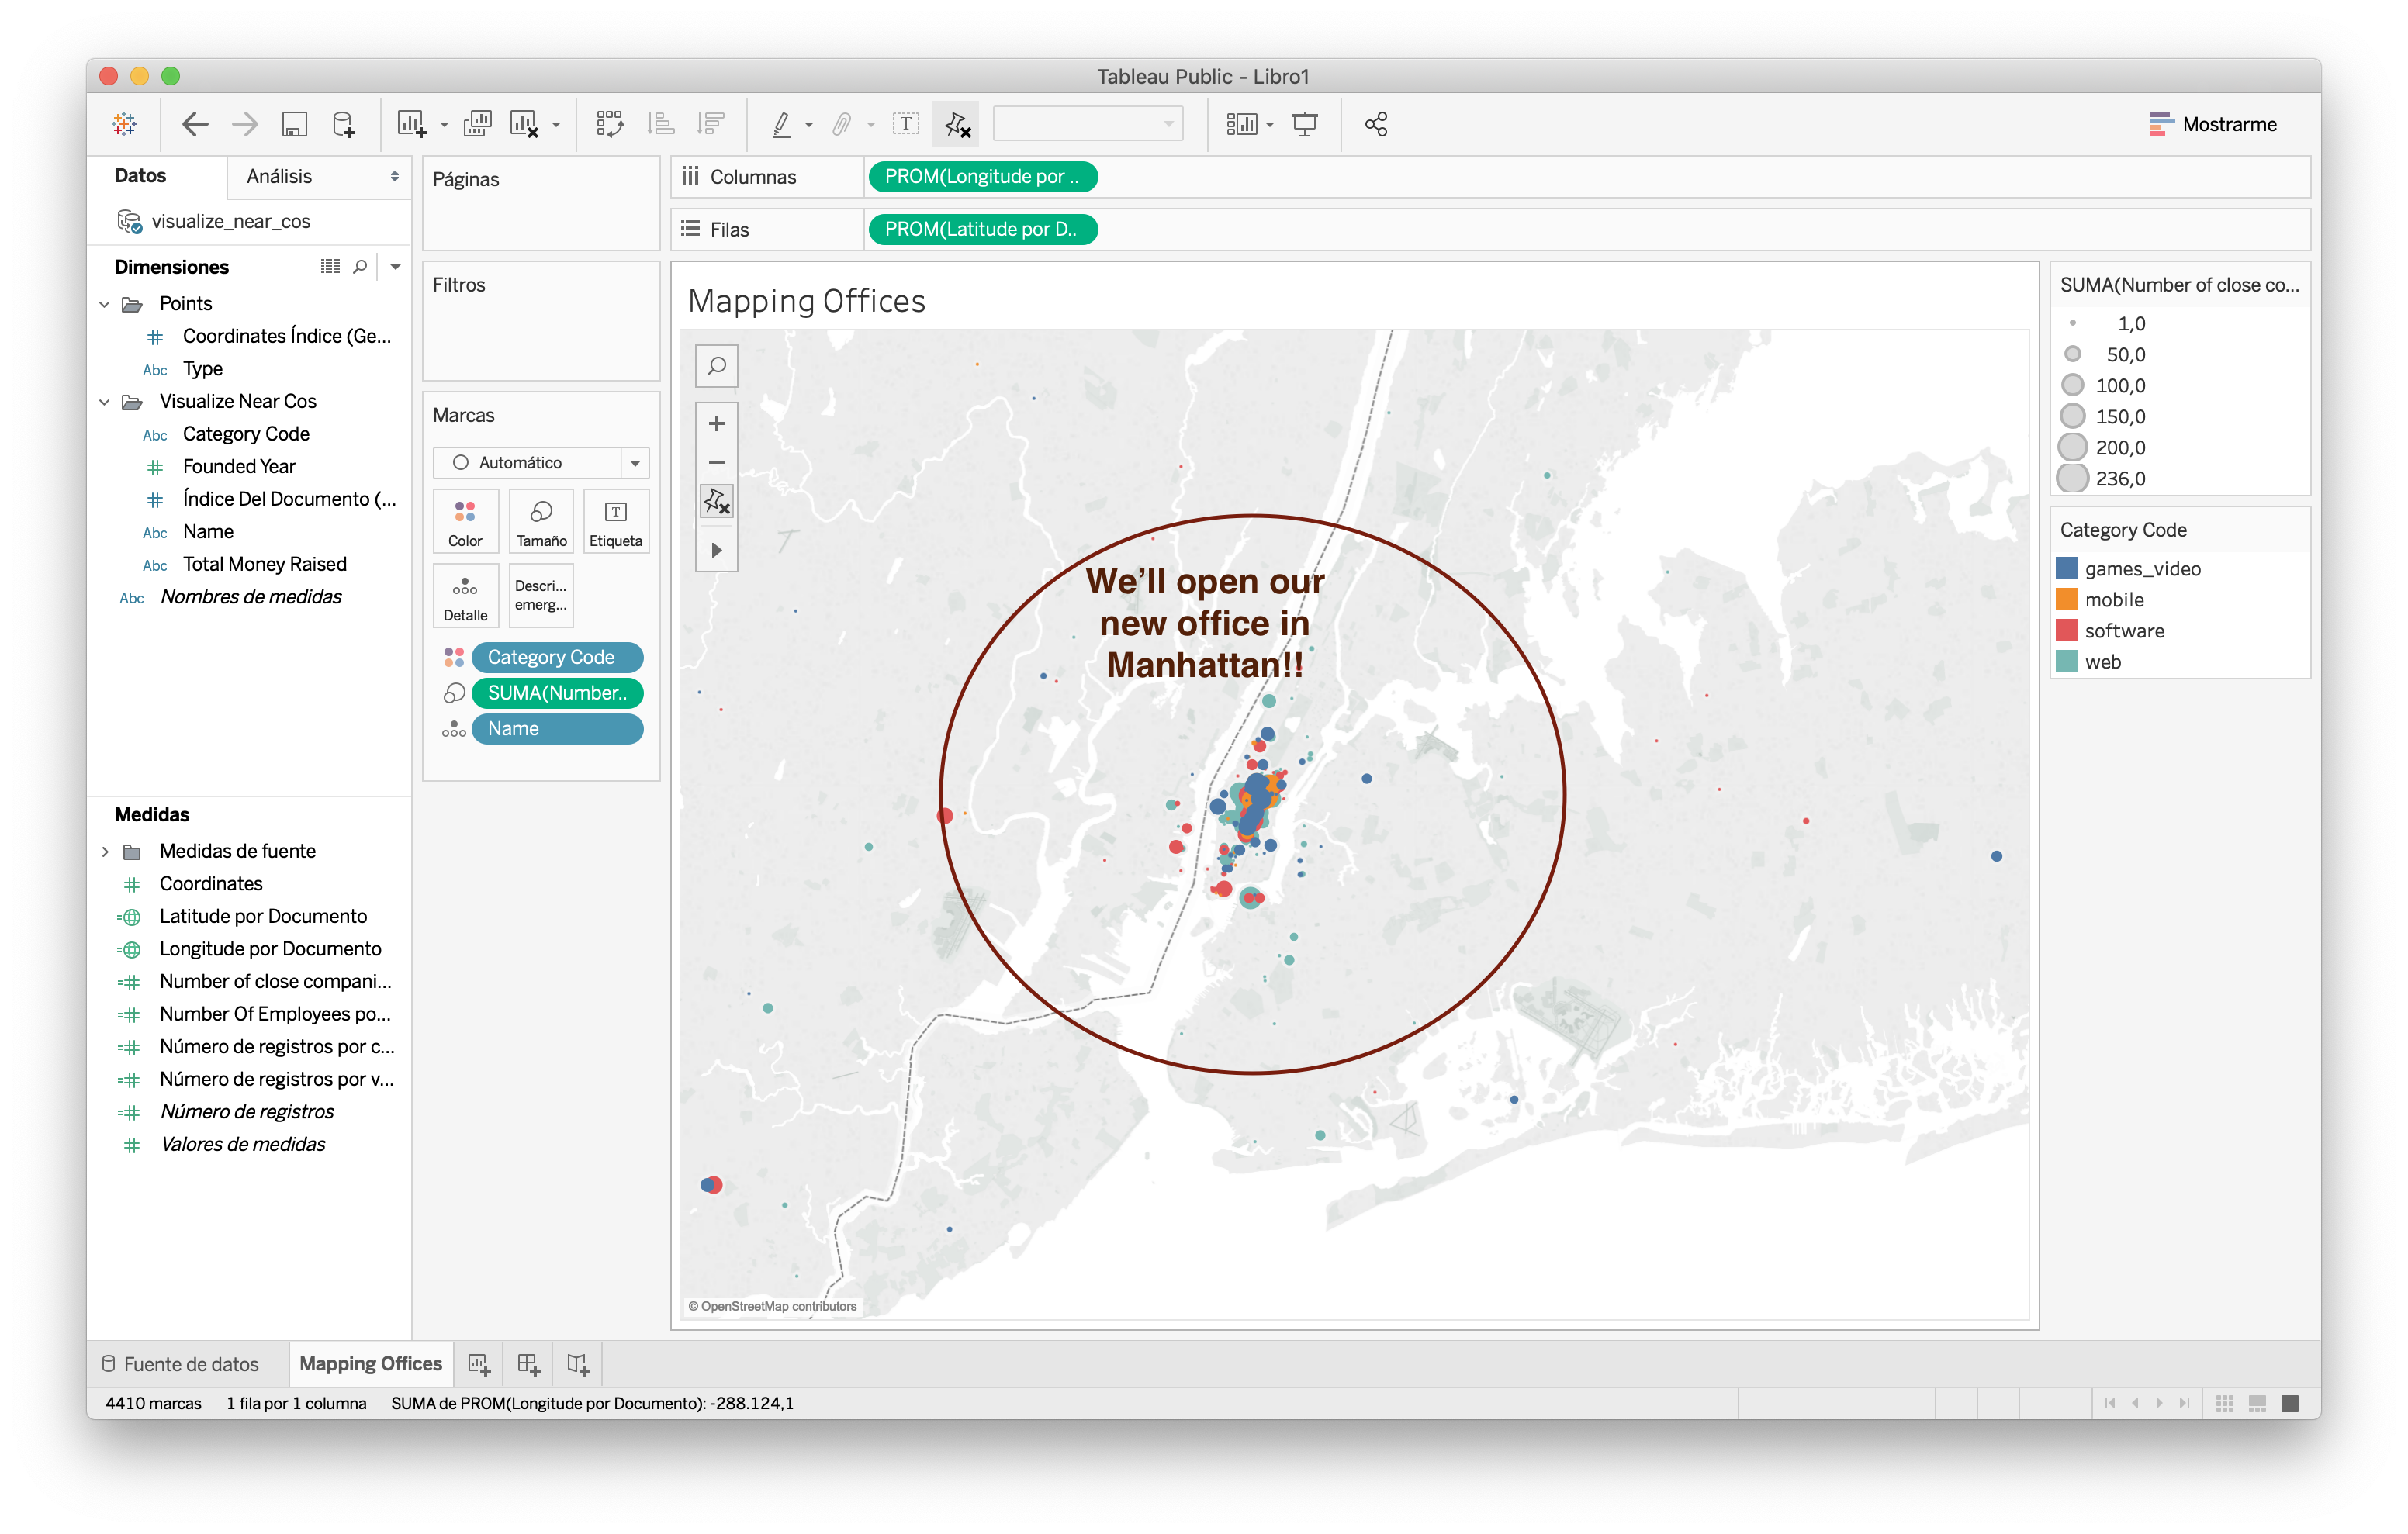

### Fin del ejercicio
#### A partir de aquí, se encuentra mi código NO EFICIENTE. No lo borro porque me interesa tenerlo

In [ ]:
'''
lats = []
lons = []
for y in listadir:
    for q in y:
        lat, lon = q.get('latitude'), q.get('longitude')
        # print(lat, lon)
        lats.append(lat)
        lons.append(lon)
            
     #No me deja iterar sobre un diccionario, solo me deja print it  (esto de abajo no me lo deja hacer)      
            
    #latlong.append(y.get('latitude'))
    #latlong.append(y.get('longitude'))
    
# for y in listadir:
  #  for q in y:
      #  q.values()
        #del q['address1']
        #q.pop('address1', None)
        
#print(q)

cos['latitude'] = lats
cos['longitude'] = lons

cos.head(20)
'''

In [80]:
'''
# Limpiar columna Address para dejar coordenadas

# Queremos tener en cuenta todas las direcciones de TODAS las oficinas de cada empresa.

# cos.iloc[0]['Address']
# cos.iloc[0]['Address'][0]['latitude']

l = []
names = []
categories = []

for i in range(3384):
    norm = json_normalize(cos.iloc[i]['Address'])
    l.append(norm)
    
    name = cos.iloc[i]['Company']
    
    for n in range(len(norm)): 
        names.append(name)
    
    categori = cos.iloc[i]['Category']
    
    for c in range(len(norm)):
        categories.append(categori)

# print(l)
'''

In [134]:
'''
wa = pd.concat(l)
wa['Company'] = names
wa['Category'] = categories
#wa
'''

In [135]:
'''
wa = wa.drop(columns=['address1', 'address2', 'city', 'country_code', 'description', 'state_code', 'zip_code'])
wa = wa.dropna(subset=['longitude'], axis=0)
print(len(wa))
wa.head()
'''

2549


,latitude,longitude,Company,Category
0,29.780549,-95.345792,BMC Software,software
0,29.527664,-98.562993,Rackspace,software
0,40.037578,-75.366299,QlikTech,software
0,34.028182,-118.472577,Cornerstone OnDemand,software
0,30.245535,-97.805621,SolarWinds,software


In [136]:
'''
points = []
for i in range(len(wa)): 
    lat = wa.iloc[i]['latitude']
    lon = wa.iloc[i]['longitude']
    point = {"type":"Point", "coordinates": [lon,lat]}
    points.append(point)

wa['points'] = points
wa.head()
'''

,latitude,longitude,Company,Category,points
0,29.780549,-95.345792,BMC Software,software,"{'type': 'Point', 'coordinates': [-95.3457921,..."
0,29.527664,-98.562993,Rackspace,software,"{'type': 'Point', 'coordinates': [-98.562993, ..."
0,40.037578,-75.366299,QlikTech,software,"{'type': 'Point', 'coordinates': [-75.366299, ..."
0,34.028182,-118.472577,Cornerstone OnDemand,software,"{'type': 'Point', 'coordinates': [-118.472577,..."
0,30.245535,-97.805621,SolarWinds,software,"{'type': 'Point', 'coordinates': [-97.805621, ..."


In [93]:
# wa.to_json("cos_with_coords.json", orient="records", lines=True)

In [94]:
# Ahora, en Terminal hay que cargar este Json en MongoDB para poner la condición $near, 
# mongoimport --db companies --collection clean  --file cos_with_coords.json (--drop así solo si quisieramos borrar el anterior)
# después hay que crear un index en el clean collection de compass, `2d sphere` index  with the `geojson` document key (Usar points de key en vez de points.coord)

In [138]:
'''
client = MongoClient()
db = client.companies
collection = db.clean

co_coords = list(collection.find({"Company":{"$exists":"true"}},{"Company":1, '_id':0, "points.coordinates":1}))

def find_near(i):
    lat = co_coords[i]["points"]["coordinates"][0]
    lgtd = co_coords[i]["points"]["coordinates"][1]

    local_cursor = collection.find({"points": {"$near": {"$geometry": {
                                                        "type": "Point" ,
                                                        "coordinates": [ lat , lgtd ]},
                                          "$minDistance": 0,
                                          "$maxDistance": 1000}}})
    return list(local_cursor)

near_list = [find_near(i) for i in range(len(co_coords))]
near_count = [len(e) for e in near_list]
#co_coords[i]["points"]["coordinates"][0]
'''

In [139]:
'''
# El máximo nos dice la empresa que más empresas tiene cerca, hay una empresa que tiene 88 empresas que nos interesan cerca

max(near_count)
'''

88

In [146]:
'''
wa["Number of close companies"] = near_count
near_cos = wa.sort_values(by = "Number of close companies", ascending = False)
near_cos.head()
'''

,latitude,longitude,Company,Category,points,Number of close companies
0,37.791391,-122.402859,Overstream,games_video,"{'type': 'Point', 'coordinates': [-122.402859,...",88
0,37.787092,-122.399972,Curse,games_video,"{'type': 'Point', 'coordinates': [-122.399972,...",84
0,38.947914,-77.342896,Axiom Software,software,"{'type': 'Point', 'coordinates': [-77.342896, ...",83
1,41.073034,-73.550452,InstallFree,software,"{'type': 'Point', 'coordinates': [-73.550452, ...",83
0,34.089679,-118.292618,CrewedUp,web,"{'type': 'Point', 'coordinates': [-118.292618,...",83


In [147]:
# near_cos.to_json("near_cos.json", orient="records", lines=True)